In [1]:
 #Summarize, explore, plot Zooplankton data from SoG surveys
# by G Oldford
# Last modified Jan 20 2022
# to-do: 

# section 1
# supplemental table 1 from 
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0245941#sec023
# MODIFIED/Perry2021_Supp1_Tab1.csv

# section 2
# look at the dominant species of each functional group 
#raw downloaded from: https://open.canada.ca/data/en/dataset/2822c11d-6b6c-437e-ad65-85f584522adc
#Ian Perry, R., Young, K., Galbraith, M., Chandler, P., Velez-Espino, A., & Baillie, S. (2021). Zooplankton variability in the Strait of Georgia, Canada, and relationships with the marine survivals of Chinook and Coho salmon. PLoS ONE, 16(1 January), e0245941. https://doi.org/10.1371/journal.pone.0245941

# to do: should adjust for seasonal bias as did Perry et al (2021) by determining season
#        calculating seasonal average biomass and then calculating average annual biomass from those. 
#        Their cutoff for inclusion in seasonal stats were 

In [2]:
library(tidyverse)
library(dplyr)
library(ggplot2)
library(stats)
library(treemapify)
library(zoo)
library(RColorBrewer)

#install.packages("treemapify", repos='http://cran.us.r-project.org')

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.2.1     v purrr   0.3.4
v tibble  2.1.3     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



# Section 1 - Pre-Aggregated Data Analysis
### using zoop groups as defined in Perry et al (2021)
supplemental table 1 from 
<br> https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0245941#sec023
<br>
<br>MODIFIED/Perry2021_Supp1_Tab1.csv


In [3]:
# note no bottom depths < 60 m in these data (already filtered)

path = "C://Users//Greig//Sync//6. SSMSP Model//Model Greig//Data//4. Zooplankton//Zoop_Perryetal_2021//MODIFIED//"
file = "Perry2021_Supp2_Tab1.csv"
path_out_TS = "C://Users//Greig//Sync//6. SSMSP Model//Model Greig//Data//4. Zooplankton//Zoop_Perryetal_2021//MODIFIED//"

a1996_2018_supp2_df <- read.csv(paste(path, file,sep=""))

# create survey depth difference field for density calc following Perry et al pers. comm. Nov 2021
a1996_2018_supp2_df['depthrange'] = abs(a1996_2018_supp2_df['startz.m'] - a1996_2018_supp2_df['endz.m'])

#print(colnames(a1996_2018_supp2_df))
head(a1996_2018_supp2_df[21:46])

#calc WW biomass density g m-2 from concentration as per Perry et al (pers comm)
# using assumption that all zoop are 85% water (mult by 6.66) and jelly as 95% water
DW_to_WW_zoop = 6.66 # default
DW_to_WW_scyphozoa = 25 # Mean from Larson, 1986 (tab 2): 5% DW; Acuna, Lopez-Urrutia, Colin 2011 - avg of aurelia (52) and cyanea (34) WW:DW
DW_to_WW_medusae = 25 # Mean from Larson, 1986 (Tab 2): 4% DW; Acuna, Lopez-Urrutia, Colin 2011 & Larson, 19- avg of Aequorea (54), WW:DW
DW_to_WW_ctenop = 25 # Based on Larson, 1986, Pleurobrachia brachei 96 percent water 
DW_to_WW_fish = 5 # Omori 1969 Tab 
DW_to_WW_lgcope = 5 # avg from Omori of several lg copepods 
DW_to_WW_medsmcope = 7 # Omori 1969, avg across several
DW_to_WW_chaetognaths = 20 # Nakamura et al, 2007
DW_to_WW_mysiids = 5.5 # Omori 1969
DW_to_WW_amphipod = 4 # Omori 1969 (avg of gammarid / hyperiid)
DW_to_WW_insect = 3.6 # Omori 1969 - water strider
DW_to_WW_larvacean = 25 # guesstimate
DW_to_WW_decapods = 10 # Larson, 1986 in Moriarty, 2009
DW_to_WW_euphs = 7.5 # avg of Omori 1969 (4.7) and Moriarty, 2009 (10)
DW_to_WW_ostrac = 4.1 #Nakamura et al, 2007
DW_to_WW_siponophora = 28 #Moriarty, 2009
DW_to_WW_others = 10 #others

mg_to_g = 0.001

# col indices for first and last indiv groups
col_beg = 21
col_end = 44

########################## WW B dens ####################################
###################################
# convert from DW to WW and to B per square m (depth int following Perry et al)

# gelatinous groups (index)
# Siphonophorae (44), Scyphozoa (43), Ctenophora (30), Larvacea (33), Medusae (34)
WW_B_conc = a1996_2018_supp2_df %>%
  mutate(across(c(21:22), ~(as.numeric(.) * DW_to_WW_amphipod))) %>%
  mutate(across(c(24), ~(as.numeric(.) * DW_to_WW_lgcope))) %>%
  mutate(across(c(25:26,37), ~(as.numeric(.) * DW_to_WW_medsmcope))) %>%
  mutate(across(c(28), ~(as.numeric(.) * DW_to_WW_chaetognaths))) %>%
  mutate(across(c(30), ~(as.numeric(.) * DW_to_WW_ctenop))) %>%
  mutate(across(c(31), ~(as.numeric(.) * DW_to_WW_euphs))) %>%
  mutate(across(c(32), ~(as.numeric(.) * DW_to_WW_fish))) %>%
  mutate(across(c(33), ~(as.numeric(.) * DW_to_WW_larvacean))) %>%
  mutate(across(c(34), ~(as.numeric(.) * DW_to_WW_medusae))) %>%
  mutate(across(c(35), ~(as.numeric(.) * DW_to_WW_mysiids))) %>%
  mutate(across(c(38), ~(as.numeric(.) * DW_to_WW_ostrac))) %>%
  mutate(across(c(43), ~(as.numeric(.) * DW_to_WW_scyphozoa))) %>%
  mutate(across(c(44), ~(as.numeric(.) * DW_to_WW_siponophora))) %>%
  mutate(across(c(23,27,29,36,39,40:42), ~(as.numeric(.) * DW_to_WW_others)))

# convert from WW mg m-3 to WW g m-2
#WW_Bdens_df = a1996_2018_supp2_df %>% 
#  mutate(across(.cols = c(col_beg:col_end),
#                .fns = ~. * depthrange * mg_to_g))  %>%
#  mutate(Total.Biomass = rowSums(. [col_beg:col_end]))

WW_Bdens_df = WW_B_conc %>%
    # convert mg to g
    mutate(across(.cols = c(col_beg:col_end),
                 .fns = ~. * mg_to_g)) %>%
    # convert g m-3 to g m-2
    mutate(across(.cols = c(col_beg:col_end),
                 .fns = ~. * depthrange)) %>%
    mutate(Total.Biomass = rowSums(. [col_beg:col_end])) %>%
    mutate(Total.Biomass.NoEuphs = rowSums(. [c(col_beg:30,32:col_end)])) %>%
    # crustaceans and other hard bodied groups (no fish, euphs, gelat)
    mutate(Total.Biomass.Hard = rowSums(. [c(21,22,24,25,26,28,29,35,36,37,38,40,41,42)])) %>%
    # soft-bodied groups (no fish, euphs, gelat)
    mutate(Total.Biomass.Soft = rowSums(. [c(27,30,33,34,39,43,44)]))


AmphiGam,AmphiHyp,BenthicLarv,CalCops.larg,CalCops.med,CalCops.smal,Cephalopoda,Chaetognatha,Cladocera,Ctenophora,...,NonCalCops,Ostracoda,Other,PolychaetPelagic,Pteropods,Repantia,Scyphozoa,Siphonophorae,Total.Biomass,depthrange
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2.49343,0.27036,0.00894,8.86572,5.63803,0.30471,0.05135,0.15047,0.00000,0,...,0.10340,2.41510,0.29042,0.97444,0.42799,0.00000,0,0.97348,27.13857,400
1.77980,0.26451,0.02184,25.75815,8.80209,0.32579,0.01075,0.17554,0.00382,0,...,0.14079,2.35396,0.00000,0.72774,0.18151,0.00000,0,0.65032,43.90583,400
4.61524,3.10915,0.88579,7.96713,11.46466,1.70843,0.00000,0.69826,0.00000,0,...,0.59765,2.01767,0.00000,2.30619,0.25985,0.01720,0,0.38782,39.34510,400
3.51086,1.65321,0.18250,10.26109,11.23684,1.38025,0.00000,0.40984,0.00000,0,...,0.44741,3.91307,0.04299,2.45235,0.42703,0.31068,0,0.11273,39.16345,400
4.69071,1.08455,0.02484,6.12007,9.92156,0.25526,0.00000,3.31445,0.00000,0,...,0.24930,1.52854,0.00000,1.41343,0.16718,0.00000,0,0.14091,32.35766,400
7.13900,1.26617,0.13864,3.69601,8.49707,1.07810,0.00000,2.50776,0.00000,0,...,0.35234,5.86960,0.00000,1.65617,0.30428,0.00000,0,0.38108,37.79185,400


Note: Using an external vector in selections is ambiguous.
i Use `all_of(col_beg)` instead of `col_beg` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
i Use `all_of(col_end)` instead of `col_end` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


In [4]:
# problematic outlier? for euphausiids lead to potentially nutty WW estimates (2500 mt / km +)
badones = WW_Bdens_df %>% filter(Total.Biomass > 1000)
badones[c(1:5,31:47)]

# dry weight mg / m-3 estimate that's probably a mistake
bighaul = a1996_2018_supp2_df %>% filter(ï..key == "PBS2009046001401")
bighaul["euphsWW_B_mt_km2"] = bighaul["Euphs"] * mg_to_g * DW_to_WW_euphs * bighaul["depthrange"]
bighaul[c(31,45:47)]

ï..key,survey,event,net,region,Euphs,Fish,Larvacea,Medusae,Mysids,...,Ostracoda,Other,PolychaetPelagic,Pteropods,Repantia,Scyphozoa,Siphonophorae,Total.Biomass,depthrange,Total.Biomass.NoEuphs
<fct>,<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
PBS1998017000401,PBS1998017,4,1,Central Strait of Georgia,1188.527,0,0.654875,21.201687,0,...,3.651603,0.00000,2.44925,4.977075,5.050425,0,2.16370,1343.930,250,155.40386
PBS2009046001401,PBS2009046,14,1,Northern Strait of Georgia,2535.916,0,13.542300,0.358425,0,...,0.000000,0.28353,0.00000,0.847725,0.000000,0,4.74726,2592.251,150,56.33478


Euphs,Total.Biomass,depthrange,euphsWW_B_mt_km2
<dbl>,<dbl>,<int>,<dbl>
2254.148,2293.246,150,2535.916


In [5]:

# set seasons following Perry et al 2021
WW_Bdens_df = WW_Bdens_df %>%
  mutate(season = case_when(mon == 12 | mon == 1 | mon == 2 ~ "winter", 
                            mon == 3 | mon == 4 | mon == 5 ~ "spring", 
                            mon == 6 | mon == 7 | mon == 8 ~ "summer", 
                            mon == 9 | mon == 10 | mon == 11 ~ "fall"))

#head(a1996_2018_supp2_df)
#nrow(a1996_2018_supp2_df)
#colnames(a1996_2018_supp2_df)
head(WW_Bdens_df[21:45])

########################## WW B Stats ####################################
###################################

print("Statistics for total.B (transformed to WW)")
summary(WW_Bdens_df$Total.Biomass)
sd(WW_Bdens_df$Total.Biomass)

print("Statistics for total.B (no Euphs)")
summary(WW_Bdens_df$Total.Biomass.NoEuphs)
sd(WW_Bdens_df$Total.Biomass.NoEuphs)

# by season
print("stats of total B by season - not for B param should 'stratify' as in next bit")
WW_Bdens_df %>%
  group_by(season) %>% 
  mutate(meanB = mean(Total.Biomass)) %>%
  mutate(stdev = sd(Total.Biomass)) %>%
  mutate(meanlogB = mean(log(Total.Biomass))) %>% 
  mutate(stddevlogB = sd(log(Total.Biomass))) %>%
  dplyr::select(season, stdev, meanB, meanlogB, stddevlogB) %>%
  summarise(meanB_ = mean(round(meanB, digits=2)),
            stdev = mean(round(stdev, digits=2)),
            meanlogB_ = mean(round(meanlogB, digits=2)),
            stddevlogB_ = mean(round(stddevlogB, digits=2)),
            n_= n()) %>%
  mutate(logmean_B1 = exp(meanlogB_ + stddevlogB_^2/2)) %>%
  mutate(logmean_B2 = exp(meanlogB_ ))

print("Summarize mean B season and year")
WW_Bdens_df %>%
  group_by(season,yr) %>% 
  mutate(meanB = mean(Total.Biomass),
         stdev = sd(Total.Biomass), 
         meanlogB = mean(log(Total.Biomass)), 
         stddevlogB = sd(log(Total.Biomass)),
         meanB_hard = mean(Total.Biomass.Hard),
         stdev_hard = sd(Total.Biomass.Hard),
         meanB_soft = mean(Total.Biomass.Soft),
         stdev_soft = sd(Total.Biomass.Soft),
        ) %>%
    # Total.Biomass.NoEuphs	Total.Biomass.Hard	Total.Biomass.Soft
  #mutate(meanB_NoEuphs = ) %>%
  dplyr::select(season, stdev, meanB, meanlogB, stddevlogB, meanB_hard, stdev_hard, meanB_soft, stdev_soft) %>%
  summarise(meanB_ = mean(round(meanB, digits=2)),
            stdev = mean(round(stdev, digits=2)),
            meanlogB_ = mean(round(meanlogB, digits=2)),
            stddevlogB_ = mean(round(stddevlogB, digits=2)),
            meanB_hard_ = mean(round(meanB_hard, digits=2)),
            stdev_hard_ = mean(round(stdev_hard, digits=2)),
            meanB_soft_ = mean(round(meanB_soft, digits=2)),
            stdev_soft_ = mean(round(stdev_soft, digits=2)),
            n_= n()) %>%
  mutate(logmean_B1 = exp(meanlogB_ + stddevlogB_^2/2)) %>%
  mutate(logmean_B2 = exp(meanlogB_ )) %>%
  ungroup() %>%
  group_by(season) %>%
  mutate(meanB_acrossyrs = mean(meanB_),
         meanB_hard_acrosssyrs = mean(meanB_hard_),
         meanB_soft_acrosssyrs = mean(meanB_soft_)) %>%
  summarise(meanB_acrossyrs_ = mean(round(meanB_acrossyrs, digits=2)),
           meanB_hard_acrosssyrs = mean(round(meanB_hard_acrosssyrs, digits=2)),
           meanB_soft_acrosssyrs = mean(round(meanB_soft_acrosssyrs, digits=2)))

# get mean of each group by season and year
print("Summarize mean B by group, season and year")
seasonal_B_summary = WW_Bdens_df %>%
    dplyr::select(,c(9,21:45,47:50)) %>%
    group_by(season,yr) %>%
    summarise_all(.funs = funs(B = round(mean(., na.rm=TRUE),digits=2))) 
#seasonal_B_summary
# WW_Bdens_df[47:49]

#print("investigate single group: ")
#seasonal_B_summary$Euphs_B

#get mean of each group by year
print("summarize mean B by group and year")
B_yr_summary = seasonal_B_summary %>%
    group_by(yr) %>%
    dplyr::select(-season) %>%
    summarise_all(.funs = funs(B = round(mean(., na.rm=TRUE),digits=2))) %>%
    pivot_longer(2:29, names_to = "group", values_to = "mean_B")
#seasonal_B_yr_summary

# seasonal_B_yr_summary can be used as EwE time series

#print("Investigate single group")
#filter(seasonal_B_yr_summary, group == "Euphs_B_B")

# Average B across years
print("Average B by group across years for model B param")
yearround_B_avg = B_yr_summary %>% 
    group_by(group) %>%
    summarise(mean_B = round(sd(mean_B, na.rm=TRUE),digits=2))
yearround_B_avg

AmphiGam,AmphiHyp,BenthicLarv,CalCops.larg,CalCops.med,CalCops.smal,Cephalopoda,Chaetognatha,Cladocera,Ctenophora,...,Natantia,NonCalCops,Ostracoda,Other,PolychaetPelagic,Pteropods,Repantia,Scyphozoa,Siphonophorae,Total.Biomass
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.989488,0.432576,0.03576,17.73144,15.78648,0.853188,0.2054,1.20376,0.00000,0,...,0.70312,0.289520,3.960764,1.16168,3.89776,1.71196,0.00000,0,10.902976,76.09853
2.847680,0.423216,0.08736,51.51630,24.64585,0.912212,0.0430,1.40432,0.01528,0,...,0.28468,0.394212,3.860494,0.00000,2.91096,0.72604,0.00000,0,7.283584,107.62397
7.384384,4.974640,3.54316,15.93426,32.10105,4.783604,0.0000,5.58608,0.00000,0,...,5.31332,1.673420,3.308979,0.00000,9.22476,1.03940,0.06880,0,4.343584,111.53466
5.617376,2.645136,0.73000,20.52218,31.46315,3.864700,0.0000,3.27872,0.00000,0,...,5.18948,1.252748,6.417435,0.17196,9.80940,1.70812,1.24272,0,1.262576,102.64321
7.505136,1.735280,0.09936,12.24014,27.78037,0.714728,0.0000,26.51560,0.00000,0,...,0.28468,0.698040,2.506806,0.00000,5.65372,0.66872,0.00000,0,1.578192,98.87478
11.422400,2.025872,0.55456,7.39202,23.79180,3.018680,0.0000,20.06208,0.00000,0,...,13.35704,0.986552,9.626144,0.00000,6.62468,1.21712,0.00000,0,4.268096,108.97737


[1] "Statistics for total.B (transformed to WW)"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   1.792   81.077  155.208  194.762  260.719 2592.251 

[1] 174.6893

[1] "Statistics for total.B (no Euphs)"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.753  63.152 119.703 147.506 204.963 692.561 

[1] 108.698

[1] "stats of total B by season - not for B param should 'stratify' as in next bit"


`summarise()` ungrouping output (override with `.groups` argument)


season,meanB_,stdev,meanlogB_,stddevlogB_,n_,logmean_B1,logmean_B2
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
fall,191.20,225.76,4.96,0.75,163,188.90609,142.59380
spring,180.44,147.95,4.85,0.91,275,193.26262,127.74039
summer,255.15,164.92,5.32,0.76,239,272.81666,204.38388
winter,75.33,62.41,4.05,0.75,83,76.03928,57.39746


[1] "Summarize mean B season and year"


Adding missing grouping variables: `yr`
`summarise()` regrouping output by 'season' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


season,meanB_acrossyrs_,meanB_hard_acrosssyrs,meanB_soft_acrosssyrs
<chr>,<dbl>,<dbl>,<dbl>
fall,186.43,92.62,23.14
spring,153.90,87.71,37.51
summer,235.47,115.62,46.32
winter,74.22,46.64,8.61


[1] "Summarize mean B by group, season and year"


Warning message:
"`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."

[1] "summarize mean B by group and year"
[1] "Average B by group across years for model B param"


`summarise()` ungrouping output (override with `.groups` argument)


group,mean_B
<chr>,<dbl>
AmphiGam_B_B,3.10
AmphiHyp_B_B,1.58
BenthicLarv_B_B,1.52
CalCops.larg_B_B,15.63
CalCops.med_B_B,10.09
CalCops.smal_B_B,1.65
Cephalopoda_B_B,0.15
Chaetognatha_B_B,5.17
Cladocera_B_B,0.09


In [5]:
# TS by yr and mo
print("Summarize mean B by group, season and year")
yrmon_mean_df = WW_Bdens_df %>%
    dplyr::select(,c(9,10,21:45,47:49)) %>%
    group_by(yr,mon) %>%
    summarise_all(.funs = funs(B = round(mean(., na.rm=TRUE),digits=2))) 
head(yrmon_mean_df)

[1] "Summarize mean B by group, season and year"


yr,mon,AmphiGam_B,AmphiHyp_B,BenthicLarv_B,CalCops.larg_B,CalCops.med_B,CalCops.smal_B,Cephalopoda_B,Chaetognatha_B,...,Other_B,PolychaetPelagic_B,Pteropods_B,Repantia_B,Scyphozoa_B,Siphonophorae_B,Total.Biomass_B,Total.Biomass.NoEuphs_B,Total.Biomass.Hard_B,Total.Biomass.Soft_B
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1996,2,3.42,0.43,0.06,34.62,20.22,0.88,0.12,1.30,...,0.58,3.40,1.22,0.00,0,9.09,91.86,82.75,70.25,12.40
1996,4,6.50,3.81,2.14,18.23,31.78,4.32,0.00,4.43,...,0.09,9.52,1.37,0.66,0,2.80,107.09,105.72,92.20,10.26
1997,1,7.51,1.74,0.10,12.24,27.78,0.71,0.00,26.52,...,0.00,5.65,0.67,0.00,0,1.58,98.87,89.08,86.30,2.68
1997,3,11.42,2.03,0.55,7.39,23.79,3.02,0.00,20.06,...,0.00,6.62,1.22,0.00,0,4.27,108.98,107.88,99.52,5.68
1997,4,1.88,0.42,0.20,1.29,4.51,0.57,0.00,2.02,...,0.00,1.62,0.65,0.10,0,0.32,27.16,16.35,14.66,0.96
1997,6,12.97,3.73,0.00,24.49,25.68,1.31,0.26,0.00,...,0.00,0.00,2.90,44.34,0,9.58,142.69,135.33,125.49,9.84


In [6]:
# haven't got this visual working yet
yrmon_mean_df %>%
    mutate(pd.to_datetime(df[['yr', 'mon']].assign(DAY=1))) + 
    ggplot( aes(x=yr, y=mean_B, group=group, color=group)) +
    theme(legend.position="bottom") +
    geom_line() + 
    scale_x_continuous(breaks = (seq(min(seasonal_B_yr_summary$yr), max(seasonal_B_yr_summary$yr), by = 2)))

ERROR: Error in parse(text = x, srcfile = src): <text>:3:44: unexpected symbol
2: yrmon_mean_df %>%
3:     mutate(pd.to_datetime(df[['yr', 'mon']].assign
                                              ^


In [7]:
B_yr_summary %>%
  #filter(group != "Total.Biomass_B_B") %>%
  filter(group == 'Total.Biomass.Hard_B_B' | group == 'Total.Biomass.Soft_B_B' |
        group == 'Euphs_B_B' | group == 'Fish_B_B' | group == 'Chaetognatha_B_B') %>%
  ggplot( aes(x=yr, y=mean_B, group=group, color=group)) +
  theme(legend.position="bottom") +
  geom_line() + 
  scale_x_continuous(breaks = (seq(min(seasonal_B_yr_summary$yr), max(seasonal_B_yr_summary$yr), by = 2)))

ERROR: Error in seq(min(seasonal_B_yr_summary$yr), max(seasonal_B_yr_summary$yr), : object 'seasonal_B_yr_summary' not found


In [8]:
B_yr_summary %>%
  #filter(group != "Total.Biomass_B_B") %>%
  filter(group == 'Fish_B_B') %>%
  ggplot( aes(x=yr, y=mean_B, group=group, color=group)) +
  theme(legend.position="bottom") +
  geom_line() + 
  scale_x_continuous(breaks = (seq(min(seasonal_B_yr_summary$yr), max(seasonal_B_yr_summary$yr), by = 2)))

ERROR: Error in seq(min(seasonal_B_yr_summary$yr), max(seasonal_B_yr_summary$yr), : object 'seasonal_B_yr_summary' not found


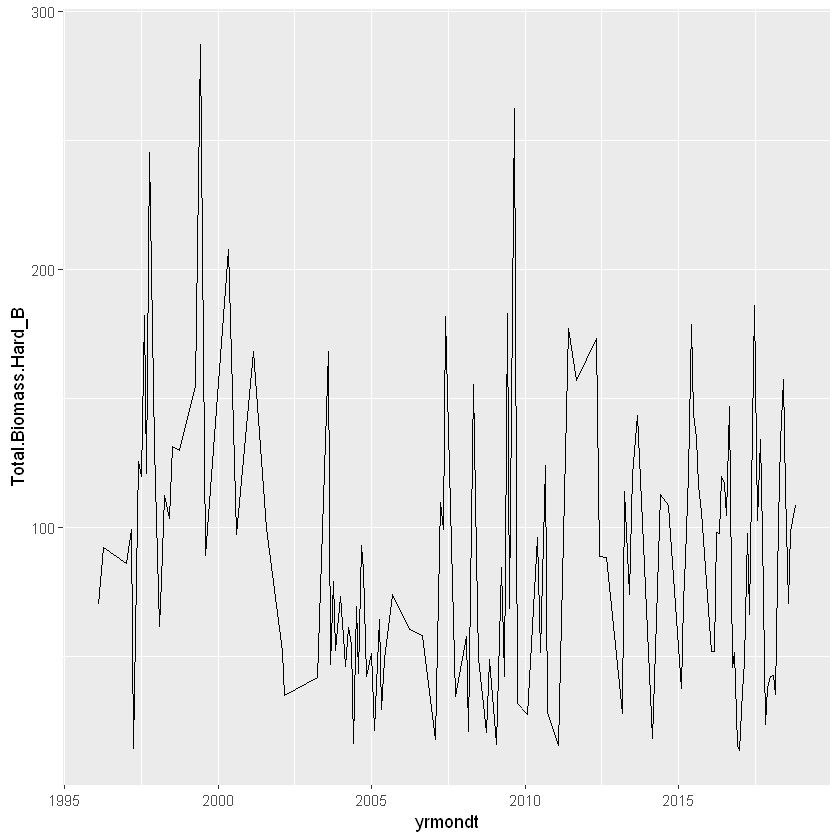

In [10]:
yrmon_mean_df$yrmondt = as.Date(paste(yrmon_mean_df$yr, yrmon_mean_df$mon,"01",sep="-"))

# i hate this plotting in ggplot and I don't understand how this actually works
yrmon_mean_df %>%
  ungroup() %>%
  select(c("Total.Biomass.Hard_B","Total.Biomass.Soft_B", "yrmondt")) %>%
  ggplot(aes(x=yrmondt, y=Total.Biomass.Hard_B)) +
  theme(legend.position="bottom") +
  geom_line() 
#+ 
 # scale_x_continuous(breaks = (seq(min(seasonal_B_yr_summary$yr), max(seasonal_B_yr_summary$yr), by = 2)))

Warning message:
"Removed 20 rows containing missing values (geom_path)."

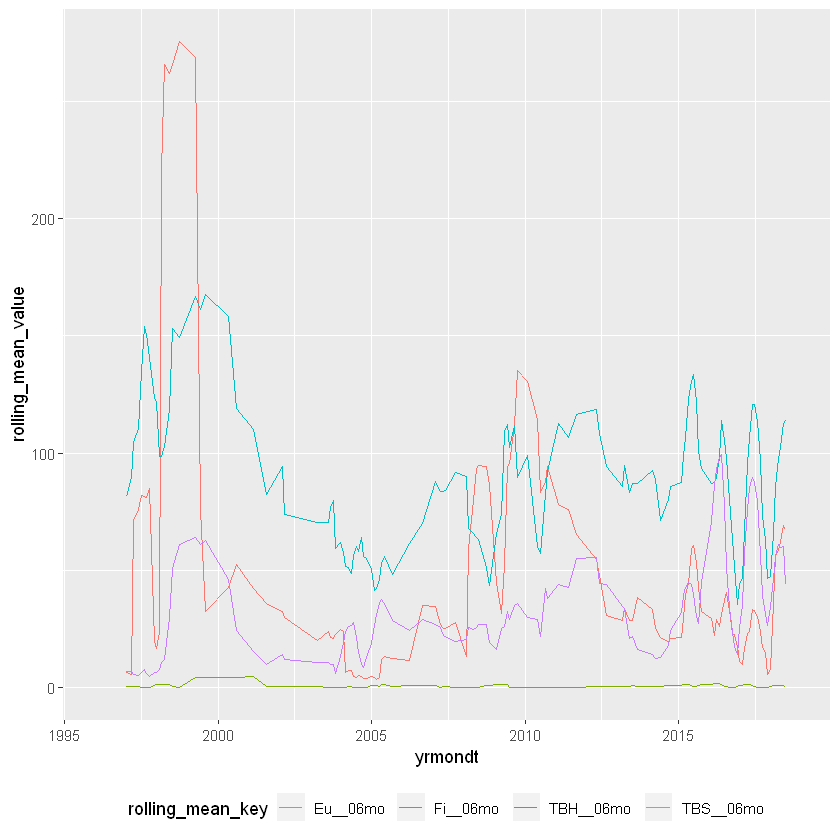

In [11]:
library(zoo) # moving averages

# to make this a nice chart remove / add groups

yrmon_mean_df %>%
    ungroup() %>%
    arrange(yrmondt) %>%
    select(c("Euphs_B","Fish_B","Total.Biomass.Hard_B","Total.Biomass.Soft_B", "yrmondt")) %>%
    dplyr::mutate(TBH_03mo = zoo::rollmean(Total.Biomass.Hard_B, k = 3, fill = NA),
                  TBH__06mo = zoo::rollmean(Total.Biomass.Hard_B, k = 6, fill = NA),
                  TBH__12mo = zoo::rollmean(Total.Biomass.Hard_B, k = 12, fill = NA),
                  TBS__03mo = zoo::rollmean(Total.Biomass.Soft_B, k = 3, fill = NA),
                  TBS__06mo = zoo::rollmean(Total.Biomass.Soft_B, k = 6, fill = NA),
                  TBS__12mo = zoo::rollmean(Total.Biomass.Soft_B, k = 12, fill = NA),
                  Eu__03mo = zoo::rollmean(Euphs_B, k = 3, fill = NA),
                  Eu__06mo = zoo::rollmean(Euphs_B, k = 6, fill = NA),
                  Eu__12mo = zoo::rollmean(Euphs_B, k = 12, fill = NA),
                  Fi__03mo = zoo::rollmean(Fish_B, k = 3, fill = NA),
                  Fi__06mo = zoo::rollmean(Fish_B, k = 6, fill = NA),
                  Fi__12mo = zoo::rollmean(Fish_B, k = 12, fill = NA)) %>% 
    pivot_longer(names_to = "rolling_mean_key", 
                 values_to = "rolling_mean_value",
                 cols = c(TBH__06mo,
                          TBS__06mo,
                          Eu__06mo,
                          Fi__06mo,
                         )) %>%
    ggplot(aes(x=yrmondt, y = rolling_mean_value, color = rolling_mean_key)) +
    theme(legend.position="bottom") +
    geom_line() 

Warning message:
"Removed 2 rows containing missing values (geom_point)."

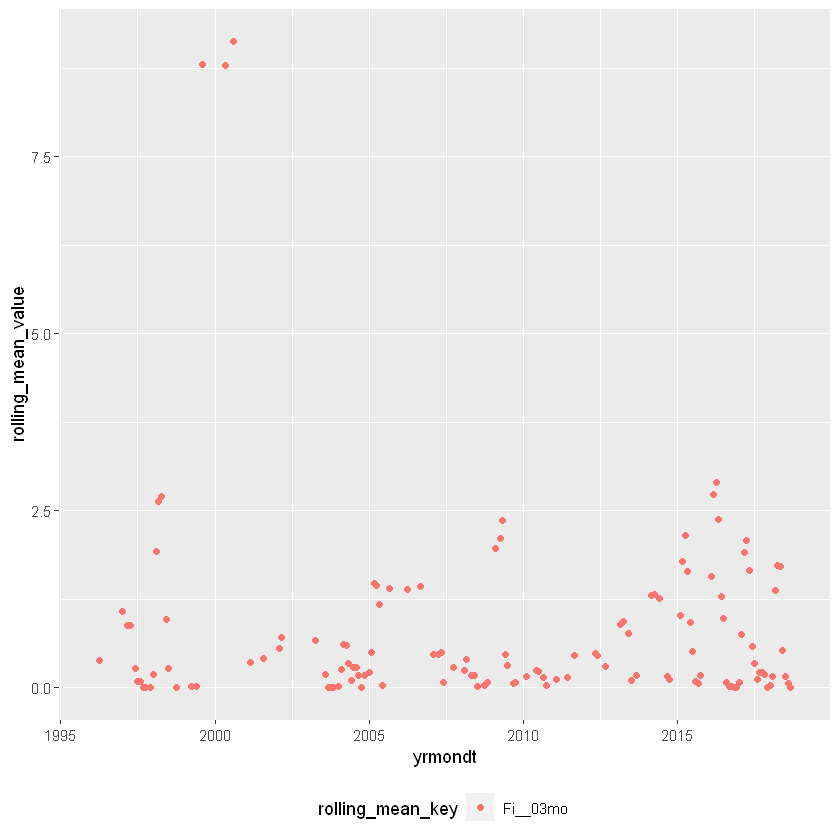

In [12]:
yrmon_mean_df %>%
    ungroup() %>%
    arrange(yrmondt) %>%
    select(c("Fish_B","yrmondt")) %>%
    dplyr::mutate(Fi__03mo = zoo::rollmean(Fish_B, k = 3, fill = NA),
                  Fi__06mo = zoo::rollmean(Fish_B, k = 6, fill = NA),
                  Fi__12mo = zoo::rollmean(Fish_B, k = 12, fill = NA)) %>% 
    pivot_longer(names_to = "rolling_mean_key", 
                 values_to = "rolling_mean_value",
                 cols = c(Fi__03mo,
                         )) %>%
    ggplot(aes(x=yrmondt, y = rolling_mean_value, color = rolling_mean_key)) +
    theme(legend.position="bottom") +
    geom_point() 

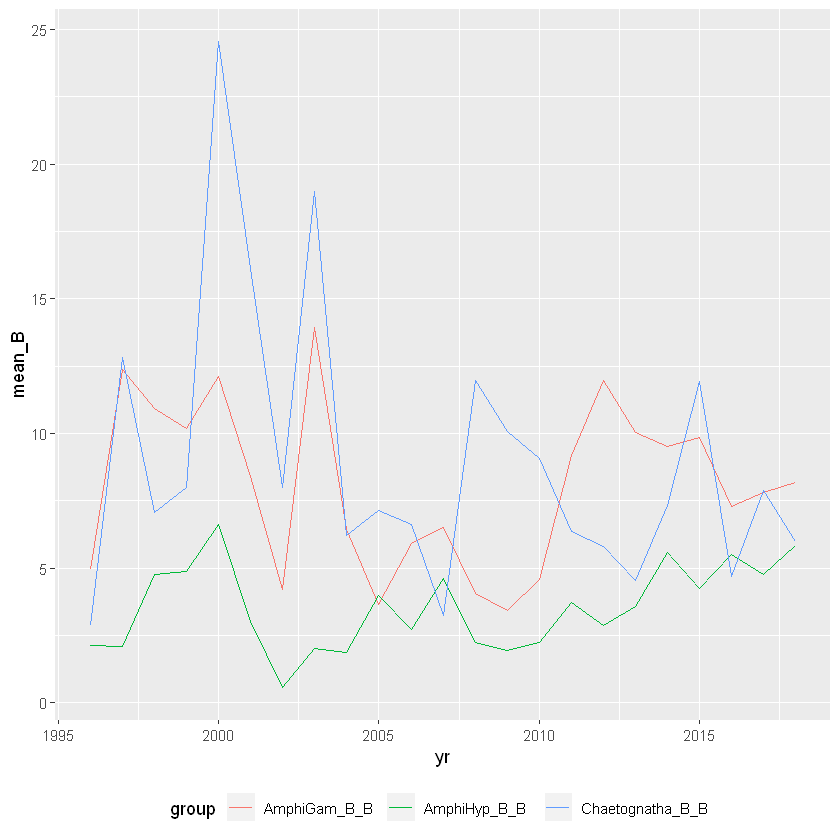

In [15]:
# to do: map to explore some distributions
# aggregate to match groups in EwE for TS
# create TS and export
B_yr_summary %>%
    filter(group == "AmphiGam_B_B" | group == "AmphiHyp_B_B" | group == "Chaetognatha_B_B") %>%
    ggplot(aes(x=yr, y = mean_B, color = group)) +
    theme(legend.position="bottom") +
    geom_line() 



In [12]:
# pivot wider and export for EwE time series

ewe_ts = B_yr_summary %>%
    pivot_wider(names_from=group,values_from=mean_B) %>%
    mutate(Z3_Amphipods_B = AmphiGam_B_B + AmphiHyp_B_B) %>%
    mutate(Z5_CalCops_B = CalCops.med_B_B + CalCops.smal_B_B) %>%
    mutate(Z2_Euphausiids = Euphs_B_B) %>%
    mutate(Z4_CopeLg = CalCops.larg_B_B) %>%
    mutate(Z1_ichthyomero = Fish_B_B) %>%
    mutate(G3_Ctenophora = Ctenophora_B_B) %>%
    mutate(G2_Medusae = Medusae_B_B)  %>%
    mutate(G1_Scyphozoa = Scyphozoa_B_B) 

write.csv(ewe_ts,paste(path_out_TS, "Perry2021_meanB_yr.csv", sep=""),row.names=FALSE)


#amphi_B_yr = B_yr_summary %>%
#    filter(group == "AmphiGam_B_B" | group == "AmphiHyp_B_B") %>%
#    group_by(yr) %>%
#    summarise(amphi_mean_B = round(sum(mean_B, na.rm=TRUE),digits=2))


# create time series for EwE
# monthly is possible but requires interpolating between missing months and adjusting
# for months with too few samples
#ts_f_amphi = "amphi_meanB_yr.csv"
#write.csv(amphi_B_yr,paste(path_out_TS,ts_f_amphi,sep=""),row.names=FALSE)

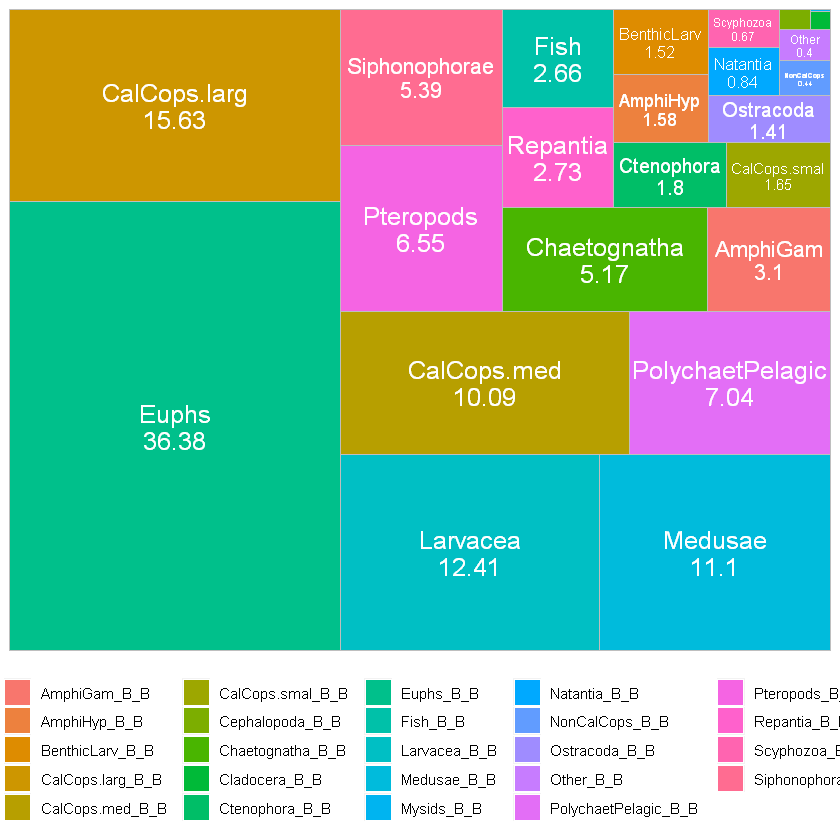

In [13]:
yearround_B_avg %>%
    filter(group != "Total.Biomass_B_B" & group != "Total.Biomass.NoEuphs_B_B" & group != "Total.Biomass.Soft_B_B" & group != "Total.Biomass.Hard_B_B") %>%
    ggplot(aes(area = mean_B, fill = group,label = paste(str_sub(group,1,nchar(group)-4),mean_B,sep="\n"))) +
    geom_treemap() + 
    geom_treemap_text(
         colour = "white",
         place = "center",
         size = 15) + theme(legend.position = "bottom")


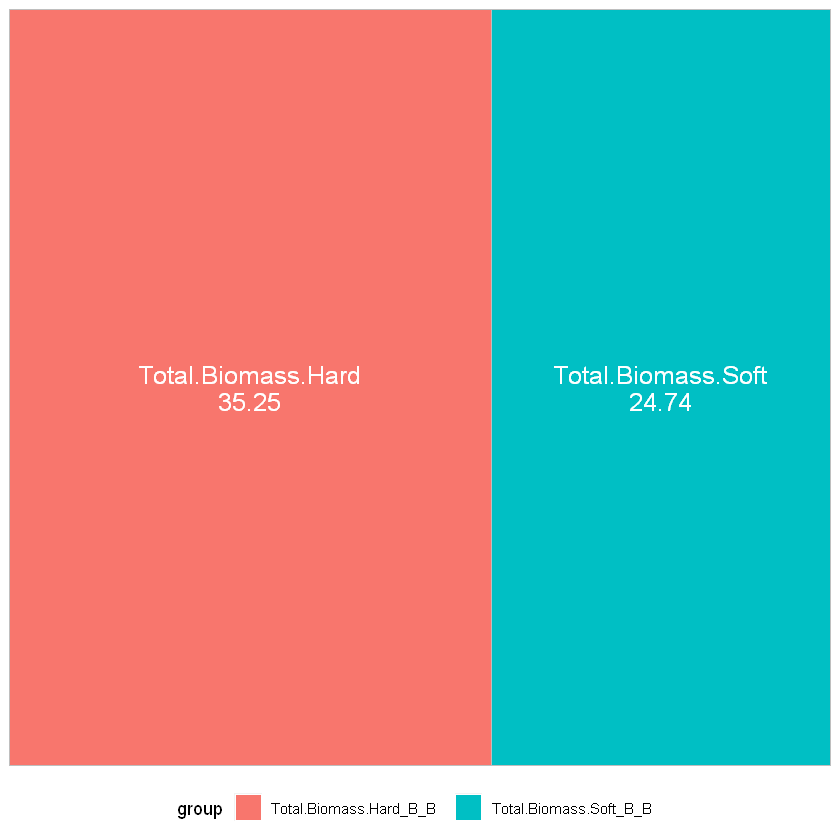

In [14]:
yearround_B_avg %>%
    filter(group == "Total.Biomass.Soft_B_B" | group == "Total.Biomass.Hard_B_B") %>%
    ggplot(aes(area = mean_B, fill = group,label = paste(str_sub(group,1,nchar(group)-4),mean_B,sep="\n"))) +
    geom_treemap() + 
    geom_treemap_text(
         colour = "white",
         place = "center",
         size = 15) + theme(legend.position = "bottom")

In [51]:
# basic meta stats on survey # etc
rows(WW_Bdens_df)

ERROR: Error in rows(WW_Bdens_df): could not find function "rows"


In [15]:
WW_Bdens_df %>% 
  group_by(yr) %>% 
  summarise(n = n())

`summarise()` ungrouping output (override with `.groups` argument)


yr,n
<int>,<int>
1996,4
1997,13
1998,20
1999,7
2000,4
2001,8
2002,9
2003,8
2004,27


# Section 2 - Un-aggregated Data Analysis
### explore dominant species of each functional group 
<br> raw downloaded from: https://open.canada.ca/data/en/dataset/2822c11d-6b6c-437e-ad65-85f584522adc
<br> Ian Perry, R., Young, K., Galbraith, M., Chandler, P., Velez-Espino, A., & Baillie, S. (2021). Zooplankton variability in the Strait of Georgia, Canada, and relationships with the marine survivals of Chinook and Coho salmon. PLoS ONE, 16(1 January), e0245941. https://doi.org/10.1371/journal.pone.0245941



In [16]:
# Boldt et al 2018 data shows mediocre year in 2000 for herring
# but Perry et al 2021 data show big year?? What species??
path = "C://Users//Greig//Sync//6. SSMSP Model//Model Greig//Data//4. Zooplankton//Zoop_Perryetal_2021//ORIGINAL//"
file = "Zoopl_SofG_1996-2018_EN.csv"

df_2 <- read.csv(paste(path, file,sep=""))
head(df_2)

# correspondence with I. Perry and K. Young Nov 16 2021
# - the mg m-2 is calculated using the tow start - end depth
# calculate the tow depth range
df_2['tow_depth_range'] = abs(df_2['Tow_start_depth.m.'])-abs(df_2['Tow_end_depth.m.'])
summary(df_2['tow_depth_range'])

## convert DW to WW using same method as previous section
# create a season field
df_2 = df_2 %>%
    mutate(B_mg_m3_DW = Abundance.m3. * Average_biomass_per_individual.mg.) %>% # convert to mg m-3
    mutate(B_g_m2_DW = B_mg_m3_DW * tow_depth_range * mg_to_g) %>%  # mg m-3 to g m-2
    # not converting to WW B yet
    mutate(season = case_when(Month == 12 | Month == 1 | Month == 2 ~ "winter", 
                            Month == 3 | Month == 4 | Month == 5 ~ "spring", 
                            Month == 6 | Month == 7 | Month == 8 ~ "summer",  
                            Month == 9 | Month == 10 | Month == 11 ~ "fall")) 
nrow(df_2)
# Perry et al selected start depths with gt 150 m and  those with start depths <150 where 
# the tow depth range was gt 70% of the water column
df_2 = df_2 %>% 
  mutate(towrange_as_prop_watercol = tow_depth_range / Bottom_depth.m.) %>%
  filter(towrange_as_prop_watercol >= 0.7 | Tow_start_depth.m. >= 150)
nrow(df_2)

arrange(df_2, desc(B_g_m2_DW), .by_group = FALSE)

# seems like the filter above was already applied

Index,Region,Station,Longitude..N.,Latitude..W.,Year,Month,Day,Time,Twilight,...,Phylum,Class,Order,Family,Genus,Species,Genus_species,Size_class_or_life_stage,Abundance.m3.,Average_biomass_per_individual.mg.
<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<fct>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
PBS1996051000101,Central Strait of Georgia,GEO1,-123.748,49.25,1996,2,12,12:00,Daylight,...,Annelida,Polychaeta,Aciculata,Tomopteridae,Tomopteris,septentrionalis,Tomopteris.septentrionalis,Tomopteris septentrionalis s2,2.86601,0.3399988
PBS1996051000101,Central Strait of Georgia,GEO1,-123.748,49.25,1996,2,12,12:00,Daylight,...,Arthropoda,Malacostraca,Amphipoda,Cyphocarididae,Cyphocaris,challengeri,Cyphocaris.challengeri,Cyphocaris challengeri s2,0.09553,3.3001151
PBS1996051000101,Central Strait of Georgia,GEO1,-123.748,49.25,1996,2,12,12:00,Daylight,...,Arthropoda,Malacostraca,Amphipoda,Cyphocarididae,Cyphocaris,challengeri,Cyphocaris.challengeri,Cyphocaris challengeri s3,0.38214,5.6999267
PBS1996051000101,Central Strait of Georgia,GEO1,-123.748,49.25,1996,2,12,12:00,Daylight,...,Arthropoda,Malacostraca,Amphipoda,Hyperiidae,Themisto,pacifica,Themisto.pacifica,Themisto pacifica M,0.04777,2.0998535
PBS1996051000101,Central Strait of Georgia,GEO1,-123.748,49.25,1996,2,12,12:00,Daylight,...,Arthropoda,Malacostraca,Amphipoda,Scinidae,Scina,borealis,Scina.borealis,Scina borealis F,0.02388,2.5904523
PBS1996051000101,Central Strait of Georgia,GEO1,-123.748,49.25,1996,2,12,12:00,Daylight,...,Arthropoda,Malacostraca,Amphipoda,Scinidae,Scina,borealis,Scina.borealis,Scina borealis M,0.03583,2.5897293


 tow_depth_range
 Min.   : 48.0  
 1st Qu.:231.0  
 Median :290.0  
 Mean   :277.2  
 3rd Qu.:344.0  
 Max.   :420.0  

[1] 81544

[1] 81544

Index,Region,Station,Longitude..N.,Latitude..W.,Year,Month,Day,Time,Twilight,...,Species,Genus_species,Size_class_or_life_stage,Abundance.m3.,Average_biomass_per_individual.mg.,tow_depth_range,B_mg_m3_DW,B_g_m2_DW,season,towrange_as_prop_watercol
<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<fct>,...,<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<dbl>
PBS2009046001401,Northern Strait of Georgia,GS07,-124.937,49.829,2009,10,9,9:42,Daylight,...,pacifica,Euphausia.pacifica,Euphausia pacifica F,87.38498,8.5000001,150,742.77234,111.41585,fall,0.7978723
IOS2018039016301,Northern Strait of Georgia,12,-124.680,49.725,2018,5,17,2:28,Night,...,pacifica,Euphausia.pacifica,Euphausia pacifica s2,268.65825,0.6500000,343,174.62786,59.89736,spring,0.9716714
IOS2015021015501,Northern Strait of Georgia,24,-124.098,49.504,2015,9,13,21:52,Night,...,pacifica,Euphausia.pacifica,Euphausia pacifica F,13.64008,8.4999993,420,115.94067,48.69508,fall,0.9882353
PBS1998017000401,Central Strait of Georgia,CPF1,-124.086,49.367,1998,7,15,21:02,Daylight,...,pacifica,Euphausia.pacifica,Euphausia pacifica F,19.90832,8.4999985,250,169.22069,42.30517,summer,1.0000000
IOS1997037008701B,Central Strait of Georgia,GEO1,-123.750,49.250,1997,10,28,12:00,Night,...,plumchrus,Neocalanus.plumchrus,Neocalanus plumchrus 5,152.85407,0.5500000,400,84.06974,33.62790,fall,1.0000000
PBS2009046001801,Northern Strait of Georgia,GS09,-124.714,49.814,2009,10,9,11:21,Daylight,...,pacifica,Euphausia.pacifica,Euphausia pacifica F,24.93639,8.4999990,140,211.95929,29.67430,fall,0.9090909
IOS2018039016101,Northern Strait of Georgia,11,-124.721,49.708,2018,5,17,1:24,Night,...,pacifica,Euphausia.pacifica,Euphausia pacifica s2,145.86325,0.6500000,293,94.81111,27.77966,spring,0.9669967
IOS2012025013601,Northern Strait of Georgia,CPF2,-124.501,49.467,2012,5,21,5:26,Daylight,...,plumchrus,Neocalanus.plumchrus,Neocalanus plumchrus 5,151.37976,0.5500000,315,83.25887,26.22654,spring,0.9692308
PBS2008014034001,Northern Strait of Georgia,GS11,-124.936,49.832,2008,7,4,16:46,Daylight,...,pacifica,Euphausia.pacifica,Euphausia pacifica F,19.81599,8.5000018,150,168.43595,25.26539,summer,0.8064516


In [17]:
# mean biomass denisty by group calculation 
# (altered in the group_by line)

# n_surveys used to avoid biasing density estimates using these presence-only data
# (absent species are not reported in these data)
n_surveys = n_distinct(df_2[c('Index')])

# table of surveys conducted per year
n_surveys_yr = df_2 %>% group_by(Year,Index) %>% 
    summarise(n = n()) %>%
    mutate(surveycount = 1) %>%
    ungroup() %>%
    group_by(Year) %>%
    summarise(count_surveys = sum(surveycount))
df_2 = inner_join(df_2, n_surveys_yr, cols = "Year")


df_2_summary = df_2 %>% 
    group_by(Phylum,Class,Order,Family,Genus,Species,Genus_species) %>%
    #group_by(Class,Order) %>%
    
    # summing below because of the bias issue with presence-only
    summarise(B_sum_g_m2_DW = sum(round(B_g_m2_DW, digits=2)),
          Body_size_mg_mean = mean(round(Average_biomass_per_individual.mg., digits=2)),
          n = n_surveys,
          n_occurrences = n()) %>%
    mutate(B_mean_g_m2_DW = round(B_sum_g_m2_DW, digits=2) / n) %>%
    arrange(desc(B_mean_g_m2_DW), .by_group = FALSE)


`summarise()` regrouping output by 'Year' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
Joining, by = "Year"
`summarise()` regrouping output by 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species' (override with `.groups` argument)


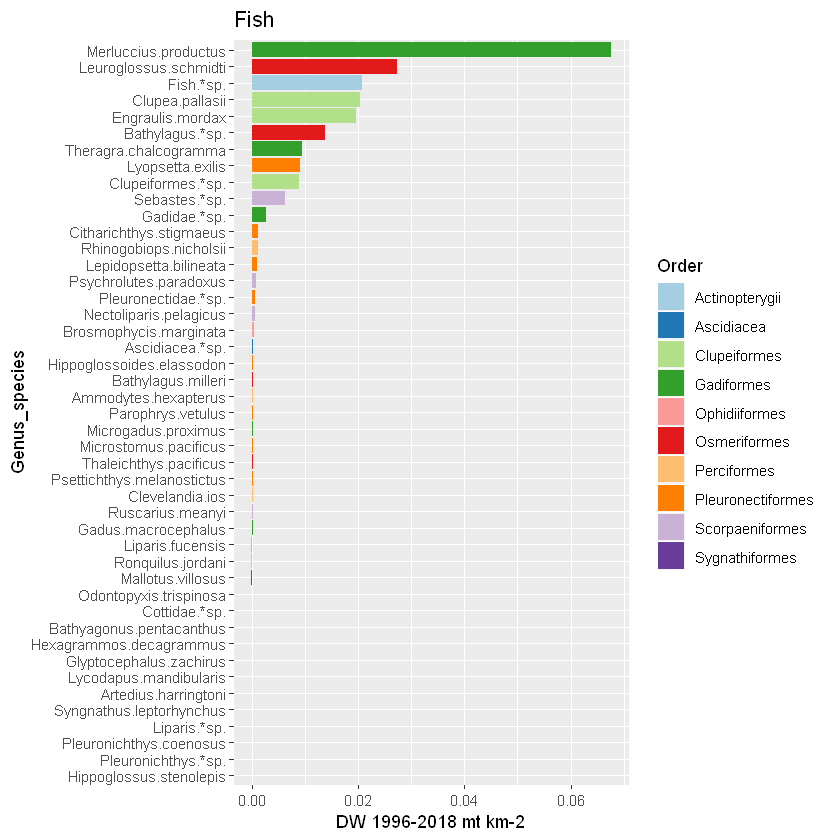

In [18]:
# fish Phylum Chordata
#df_2 %>% filter(Phylum=="Chordata")
df_2_summary_fish = df_2_summary %>% 
                    arrange(desc(B_mean_g_m2_DW)) %>% 
                    filter(Phylum=="Chordata" & B_mean_g_m2_DW >= 2.034211e-05 & 
                          Class!="Appendicularia")

# Basic barplot
p<-ggplot(data=df_2_summary_fish, 
          aes(x=reorder(Genus_species,B_mean_g_m2_DW), 
              y=B_mean_g_m2_DW, 
              fill=Order)) +
    geom_bar(stat="identity") +
    scale_fill_brewer(palette="Paired") +
    labs(title="Fish", x="Genus_species", y="DW 1996-2018 mt km-2")
# note https://www.r-graph-gallery.com/38-rcolorbrewers-palettes.html

# Horizontal bar plot
p + coord_flip()

# Leuroglossus schmidti = Northern Smoothtongue
# Bathylagus milleri  = deep sea smelt / owlfish / 
# Merluccius productus = hake

In [19]:
# Summary by year mean
df_2_yr_mean = df_2 %>% 
    group_by(Year,Phylum,Class,Order,Family,Genus,Species,Genus_species) %>%
    #group_by(Class,Order) %>%
    # summing here because of presence-only bias
    summarise(B_sum_g_m2_DW = sum(round(B_g_m2_DW, digits=2)),
          Body_size_mg_mean = mean(round(Average_biomass_per_individual.mg., digits=2)),
          n_surv_yr = mean(count_surveys), # FIX! Not relevant by year
          n_occurrences = n()) %>%
    mutate(B_mean_g_m2_DW = round(B_sum_g_m2_DW, digits=2) / n_surv_yr) %>%
    arrange(desc(B_mean_g_m2_DW), .by_group = FALSE)
    


`summarise()` regrouping output by 'Year', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species' (override with `.groups` argument)


In [26]:
df_2_yr_mean

Year,Phylum,Class,Order,Family,Genus,Species,Genus_species,B_sum_g_m2_DW,Body_size_mg_mean,n_surv_yr,n_occurrences,B_mean_g_m2_DW
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1997,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,115.05,0.47043478,13,23,8.850000
2000,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,29.70,0.55000000,4,4,7.425000
1999,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,51.70,0.42500000,7,10,7.385714
2008,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Euphausia,pacifica,Euphausia.pacifica,188.87,4.96861538,30,65,6.295667
1998,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Euphausia,pacifica,Euphausia.pacifica,111.90,5.08170732,20,41,5.595000
2011,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,49.87,0.56500000,9,6,5.541111
1996,Arthropoda,Maxillopoda,Calanoida,Calanidae,Neocalanus,plumchrus,Neocalanus.plumchrus,19.65,0.38294118,4,17,4.912500
2009,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Euphausia,pacifica,Euphausia.pacifica,216.65,4.24544000,46,125,4.709783
2011,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Euphausia,pacifica,Euphausia.pacifica,41.32,4.50800000,9,25,4.591111


`summarise()` ungrouping output (override with `.groups` argument)


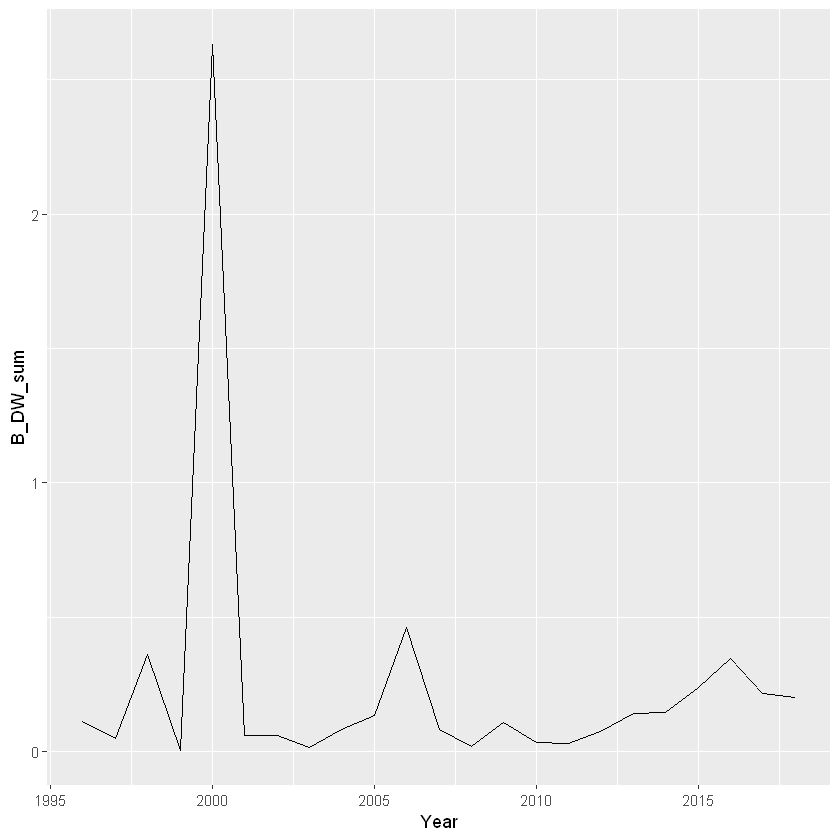

In [20]:
df_2_yr_mean_fish = df_2_yr_mean %>%
    filter(Phylum=="Chordata" & Class!="Appendicularia")
    #filter(Genus_species == "Leuroglossus.schmidti")
    #dplyr::mutate(Fi__03mo = zoo::rollmean(Fish_B, k = 3, fill = NA),
    #              Fi__06mo = zoo::rollmean(Fish_B, k = 6, fill = NA),
    #              Fi__12mo = zoo::rollmean(Fish_B, k = 12, fill = NA)) %>% 
    #pivot_longer(names_to = "rolling_mean_key", 
    #             values_to = "rolling_mean_value",
    #             cols = c(Fi__03mo,
    #                     )) %>%


df_2_yr_mean_allfishtogether = df_2_yr_mean_fish %>%
    group_by(Year) %>%
    summarise(B_DW_sum = sum(round(B_mean_g_m2_DW, digits=6)))

ggplot(data=df_2_yr_mean_allfishtogether,aes(x=Year, y = B_DW_sum)) +
    theme(legend.position="bottom") +
    geom_line() 

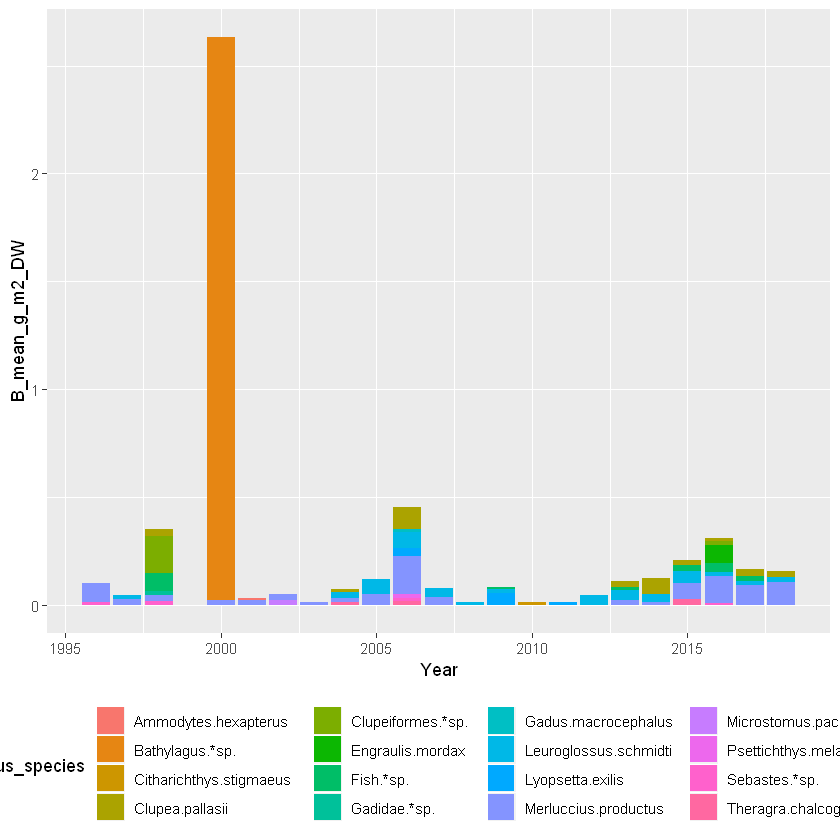

In [21]:
ggplot(filter(df_2_yr_mean_fish, B_mean_g_m2_DW > 0.01), aes(fill=Genus_species, y=B_mean_g_m2_DW, x=Year)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom")

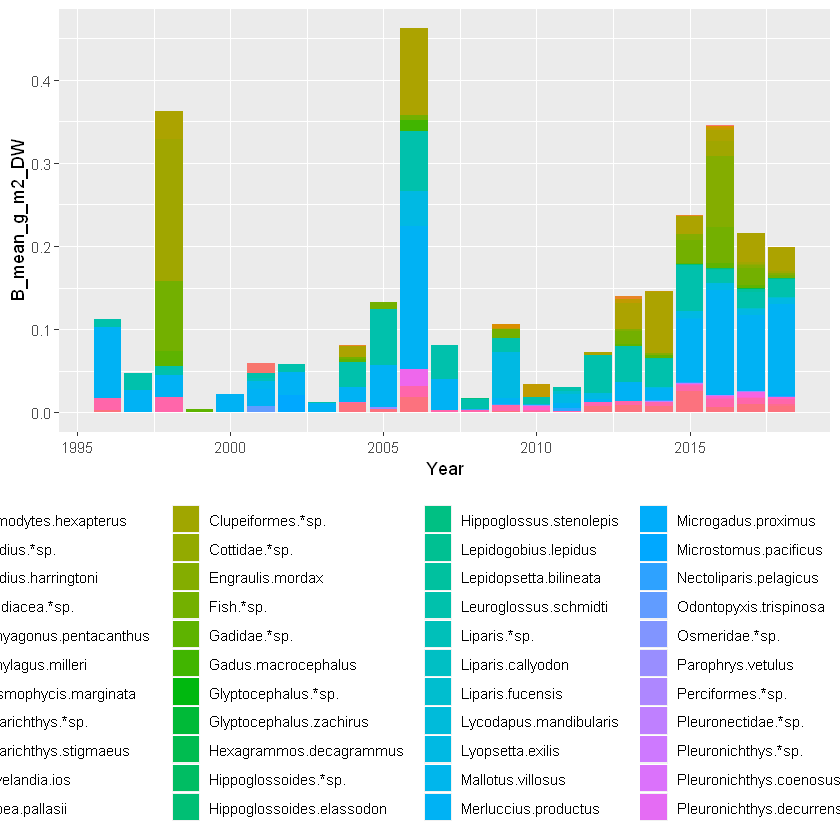

In [22]:
ggplot(filter(df_2_yr_mean_fish, Genus_species != "Bathylagus.*sp."), aes(fill=Genus_species, y=B_mean_g_m2_DW, x=Year)) + 
    geom_bar(position="stack", stat="identity") +  
    theme(legend.position="bottom")

In [23]:
df_2_yr_mean_fish %>% filter(Genus_species == "Bathylagus.*sp.")

Year,Phylum,Class,Order,Family,Genus,Species,Genus_species,B_sum_g_m2_DW,Body_size_mg_mean,n_surv_yr,n_occurrences,B_mean_g_m2_DW
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
2000,Chordata,Actinopterygii,Osmeriformes,Bathylagidae,Bathylagus,*sp.,Bathylagus.*sp.,10.44,76.30,4,1,2.6100000000
2014,Chordata,Actinopterygii,Osmeriformes,Bathylagidae,Bathylagus,*sp.,Bathylagus.*sp.,0.01,0.02,37,2,0.0002702703
2015,Chordata,Actinopterygii,Osmeriformes,Bathylagidae,Bathylagus,*sp.,Bathylagus.*sp.,0.01,0.02,137,1,0.0000729927
2004,Chordata,Actinopterygii,Osmeriformes,Bathylagidae,Bathylagus,*sp.,Bathylagus.*sp.,0.00,0.02,27,1,0.0000000000
2006,Chordata,Actinopterygii,Osmeriformes,Bathylagidae,Bathylagus,*sp.,Bathylagus.*sp.,0.00,0.02,9,1,0.0000000000
2008,Chordata,Actinopterygii,Osmeriformes,Bathylagidae,Bathylagus,*sp.,Bathylagus.*sp.,0.00,0.02,30,2,0.0000000000


`summarise()` ungrouping output (override with `.groups` argument)


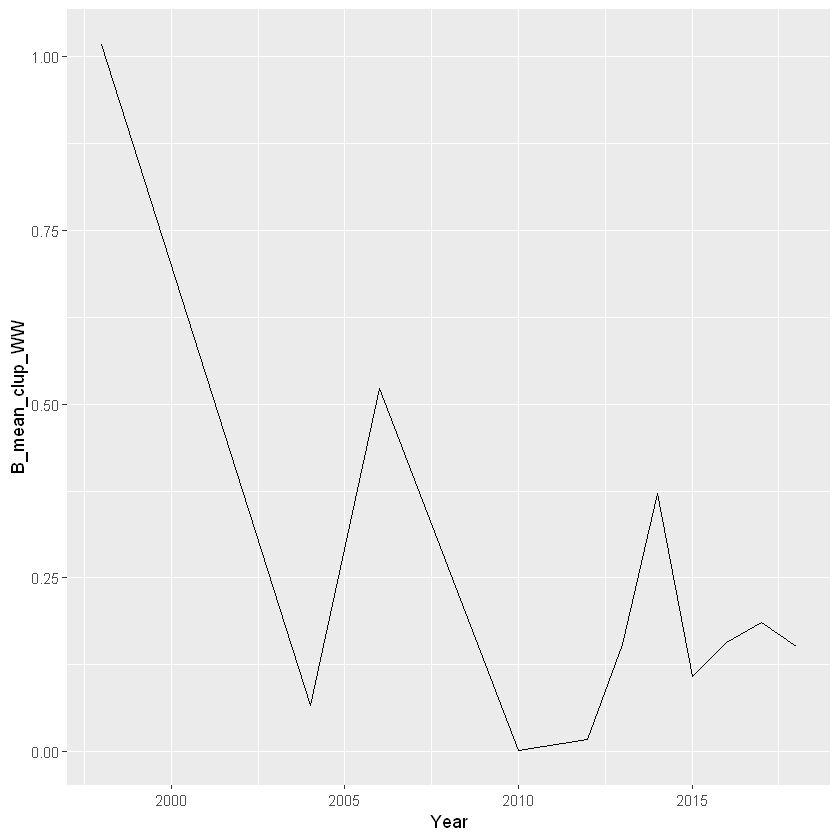

In [24]:
# grab just herring to compare to Boldt's stats

df_2_yr_mean_fish %>% 
filter(Genus_species == "Clupeiformes.*sp." | Genus_species == "Clupea.pallasii") %>%
group_by(Year) %>%
arrange(Year) %>%
summarize(B_mean_clup_WW = sum(B_mean_g_m2_DW * 5)) %>% 

ggplot(y=B_mean_clup_WW, x=Year) + 
geom_line(aes(y=B_mean_clup_WW, x=Year)) +
    theme(legend.position="bottom")
# 

In [88]:
# grab hake as separate TS

df_2_yr_mean_fish %>% 

Year,Phylum,Class,Order,Family,Genus,Species,Genus_species,B_sum_g_m2_DW,Body_size_mg_mean,n_surv_yr,n_occurrences,B_mean_g_m2_DW
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1998,Chordata,Actinopterygii,Clupeiformes,Clupeiformes,Clupeiformes,*sp.,Clupeiformes.*sp.,3.41,2.600000,20,1,0.1705000000
1998,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.66,6.870000,20,2,0.0330000000
2004,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.36,4.023333,27,3,0.0133333333
2006,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.94,4.735000,9,2,0.1044444444
2010,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.01,2.600000,21,1,0.0004761905
2012,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.06,6.870000,17,2,0.0035294118
2013,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.83,3.667500,27,4,0.0307407407
2014,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,2.75,4.735000,37,2,0.0743243243
2015,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,2.92,4.655833,137,24,0.0213138686


In [25]:
df_2_yr_mean_fish %>% filter(Genus == "Clupeiformes" | Genus == "Clupea") 

Year,Phylum,Class,Order,Family,Genus,Species,Genus_species,B_sum_g_m2_DW,Body_size_mg_mean,n_surv_yr,n_occurrences,B_mean_g_m2_DW
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1998,Chordata,Actinopterygii,Clupeiformes,Clupeiformes,Clupeiformes,*sp.,Clupeiformes.*sp.,3.41,2.600000,20,1,0.1705000000
2006,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.94,4.735000,9,2,0.1044444444
2014,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,2.75,4.735000,37,2,0.0743243243
2017,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,3.19,4.735000,93,16,0.0343010753
1998,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.66,6.870000,20,2,0.0330000000
2013,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,0.83,3.667500,27,4,0.0307407407
2018,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,1.65,5.345000,60,14,0.0275000000
2015,Chordata,Actinopterygii,Clupeiformes,Clupeidae,Clupea,pallasii,Clupea.pallasii,2.92,4.655833,137,24,0.0213138686
2016,Chordata,Actinopterygii,Clupeiformes,Clupeiformes,Clupeiformes,*sp.,Clupeiformes.*sp.,2.88,0.795000,158,20,0.0182278481
